## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [7]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [8]:
torch.cuda.get_device_capability(0)

(8, 9)

In [9]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom',
                       interpolation='none')

#### Setup hparams

In [10]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [11]:
checkpoint_path = "outdir/checkpoint_121000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
model.cuda().eval()

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

#### Load WaveGlow for mel2audio synthesis and denoiser

In [6]:
waveglow_path = 'waveglow/checkpoints/waveglow_140000'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

RuntimeError: nvrtc: error: invalid value for --gpu-architecture (-arch)

nvrtc compilation failed: 

#define NAN __int_as_float(0x7fffffff)
#define POS_INFINITY __int_as_float(0x7f800000)
#define NEG_INFINITY __int_as_float(0xff800000)


template<typename T>
__device__ T maximum(T a, T b) {
  return isnan(a) ? a : (a > b ? a : b);
}

template<typename T>
__device__ T minimum(T a, T b) {
  return isnan(a) ? a : (a < b ? a : b);
}


#define __HALF_TO_US(var) *(reinterpret_cast<unsigned short *>(&(var)))
#define __HALF_TO_CUS(var) *(reinterpret_cast<const unsigned short *>(&(var)))
#if defined(__cplusplus)
  struct __align__(2) __half {
    __host__ __device__ __half() { }

  protected:
    unsigned short __x;
  };

  /* All intrinsic functions are only available to nvcc compilers */
  #if defined(__CUDACC__)
    /* Definitions of intrinsics */
    __device__ __half __float2half(const float f) {
      __half val;
      asm("{  cvt.rn.f16.f32 %0, %1;}\n" : "=h"(__HALF_TO_US(val)) : "f"(f));
      return val;
    }

    __device__ float __half2float(const __half h) {
      float val;
      asm("{  cvt.f32.f16 %0, %1;}\n" : "=f"(val) : "h"(__HALF_TO_CUS(h)));
      return val;
    }

  #endif /* defined(__CUDACC__) */
#endif /* defined(__cplusplus) */
#undef __HALF_TO_US
#undef __HALF_TO_CUS

typedef __half half;

extern "C" __global__
void fused_tanh_sigmoid_mul(half* tv_, half* tv__, half* aten_mul) {
{
  float v = __half2float(tv__[(long long)(threadIdx.x) + 512ll * (long long)(blockIdx.x)]);
  float v_1 = __half2float(tv_[(long long)(threadIdx.x) + 512ll * (long long)(blockIdx.x)]);
  aten_mul[(long long)(threadIdx.x) + 512ll * (long long)(blockIdx.x)] = __float2half((tanhf(v)) * (1.f / (1.f + (expf(0.f - v_1)))));
}
}


#### Prepare text input

90 C3e,K4es C3s A3s C3e,K4ee E4e ] F4e,J4es A3s K3s A3e,I4ee C3e ] D4es,H4e H4s F4s D4ee,H4e I4e


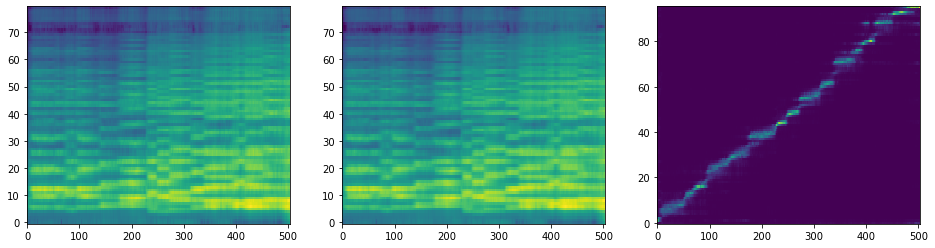

In [15]:
import os

line = "minji-kim_bwv1003_mov2_79.wav|90 C3e,K4es C3s A3s C3e,K4ee E4e ] F4e,J4es A3s K3s A3e,I4ee C3e ] D4es,H4e H4s F4s D4ee,H4e I4e"
score, text = line.split('|')

text = text.replace('\n', '')
print(text)

sequence = np.array(text_to_sequence(text, ['ptp_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

a = mel_outputs.float().data.cpu()[0]
b = mel_outputs_postnet.float().data.cpu()[0]
c = alignments.float().data.cpu()[0].T

os.makedirs(f'waveglow/mels/{score}', exist_ok=True)

torch.save(a, f'waveglow/mels/{score}/mel.pt')
torch.save(b, f'waveglow/mels/{score}/mel_postnet.pt')

plot_data((mel_outputs.float().data.cpu().numpy()[0],
        mel_outputs_postnet.float().data.cpu().numpy()[0],
        alignments.float().data.cpu().numpy()[0].T))

#### Decode text input and plot results

#### Synthesize audio from spectrogram using WaveGlow

In [9]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

NameError: name 'waveglow' is not defined

#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)